In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
%matplotlib inline
import csv
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from pathlib import Path


In [3]:
from collections import defaultdict

In [4]:

from datetime import datetime

### Importing WasteWater by County CSV 

In [5]:
df_ww= pd.read_csv('wastewater_by_county.csv', index_col=[0])

In [6]:
#converting sampling week to DateTime format
df_ww['sampling_week']= pd.to_datetime(df_ww['sampling_week'], format='%Y-%m-%d')

In [7]:
# converting dates to day of the week 0-Monday to 6-Sunday
# df_ww['sampling_week_num']= df_ww['sampling_week'].dt.dayofweek

In [8]:
df_ww['sampling_week']= df_ww.sampling_week + pd.Timedelta(days=2)

In [9]:
df_ww= df_ww.loc[(df_ww['sampling_week'] >= '2021-01-01')]

_______

### Importing Labor Force (Unemployment) by County CSV 

In [10]:
#read labor force csv in, ignorning nans, and setting the header row, skipping last 3 rows
df_lf= pd.read_csv('/Users/leratsayukova/DataJam/RemoteCloneRepo/laucntycur14.csv',
                   na_filter=False,
                   header=4,
                   skipfooter=3, engine= 'python', cache_dates=True)

In [11]:
#dropping blank row
df_lf.drop([0], axis=0, inplace=True)

In [12]:
#renaming columns 
df_lf.rename({'Code': 'State_Fips', 'Code.1': 'County_Fips', 
                   'County Name/State Abbreviation': 'County_Name_State',
                   'Force':'Labor_force', '(%)': 'Unemployment_rate(%)'
                  }, axis='columns', inplace=True)

In [13]:
#converting appropriate columsn (cols) to numeric type
cols = ['Labor_force',
 'Employed',
 'Unemployed',]
df_lf[cols] = df_lf[cols].apply(lambda x: pd.to_numeric(x.astype(str)
                                                   .str.replace(',',''), errors='coerce'))


In [14]:
#converting UE rate% column to float type
df_lf['Unemployment_rate(%)']=df_lf['Unemployment_rate(%)'].astype(float, errors='raise')

In [15]:
#create new column byadding together state and county fips code 
df_lf['Fips_code']= df_lf['State_Fips'] + df_lf['County_Fips']
df_lf['Fips_code']= df_lf['Fips_code'].astype('int64', errors='raise')

In [16]:
#removing the 'p' (preliminary) for dates in the Period Column only applies to Feb 22 on
df_lf['Period']= df_lf['Period'].map(lambda x: x.rstrip('p'))

#removing extra spaces at end of string
df_lf['Period']= df_lf['Period'].map(lambda x: x.rstrip(' '))

#converting Period column to DateTime format
df_lf['Period']= pd.to_datetime(df_lf['Period'], format='%b-%y')

________

### Importing Testing and Hospitalizations by County CSV 

In [17]:
df_19= pd.read_csv('/Users/leratsayukova/DataJam/RemoteCloneRepo/Weekly-Hospital-Level-With-Pop-and-County-Names-04-13-2022 (2).csv', 
               keep_default_na=True, cache_dates=True)

In [18]:
df_19['Perc_used_covid_over_pop']=df_19.Perc_used_covid_over_pop.astype(str)
df_19['Perc_used_covid_over_pop']=df_19['Perc_used_covid_over_pop'].map(lambda x: 
                                                                     x.rstrip('%'))

In [19]:
#change collection week to datetime time
df_19['collection_week']= pd.to_datetime(df_19['collection_week'], format='%m/%d/%y', 
                                     infer_datetime_format=True)

# #collection_week new column pd datetime dayofweek where Monday=0 & Sunday=6
# df['collection_week_num']= df['collection_week'].dt.dayofweek


# roll up collection week to two days later
df_19['collection_week']= df_19.collection_week + pd.Timedelta(days=7)


In [20]:
# #check what day rolled up to
# df.collection_week_num.value_counts()

In [21]:
cols_int= ['fips_code','MEAN_of_pop_2019']
cols_float= ['MEAN_of_total_beds_7_day_avg',
             'MEAN_of_inpatient_beds_used_covid_7_day_avg', 
             'Perc_used_covid_over_pop','MEAN_of_unemployment_rate_2019',
             'MEAN_of_uninsured_2019']

In [22]:
df_19[cols_int]= df_19[cols_int].apply(lambda x: pd.to_numeric(x, downcast='signed',
                                                                 errors='coerce'))
 

In [23]:
df_19[cols_float]= df_19[cols_float].apply(lambda x: pd.to_numeric(x,
                                                                   errors='coerce'))

### Merging all dataframes

In [24]:
# renaming all fips codes columns in datasets to be identical 
df_lf= df_lf.rename(columns= {'Fips_code':'fipscode'})
df_19= df_19.rename(columns= {'fips_code':'fipscode'})

In [25]:
# renaming all dates codes columns in datasets to be identical 
df_ww= df_ww.rename(columns= {'sampling_week': 'date'})
df_lf= df_lf.rename(columns= {'Period':'date'})
df_19= df_19.rename(columns= {'collection_week': 'date'})

In [26]:
# #chopping off day in date
df_lf['date']= pd.to_datetime(df_lf['date'],
                                 format='%Y-%m-%d').apply(lambda x: x.strftime('%Y-%m'))


# df_ww['date']= pd.to_datetime(df_ww['date'], 
#                                      format='%Y-%m-%d').apply(lambda x: x.strftime('%Y-%m'))

# df_19['date']= pd.to_datetime(df_lf['date'],
#                                  format='%Y-%m-%d').apply(lambda x: x.strftime('%Y-%m'))

In [27]:
df_lf['date']= pd.to_datetime(df_lf['date'], format='%Y-%m')

In [28]:
print('shape of Wastewater data: ' , df_ww.shape)
print('shape of Labor force data: ' , df_lf.shape)
print('shape of Hospitalizations data: ' , df_19.shape)

shape of Wastewater data:  (2968, 6)
shape of Labor force data:  (45068, 10)
shape of Hospitalizations data:  (162863, 11)


In [29]:
import datetime as dt

In [30]:
#creating a column to merge on 
df_ww['merg_col'] = df_ww['date'].dt.strftime("%Y%m")
df_lf['merg_col'] = df_lf['date'].dt.strftime("%Y%m")
df_19['merg_col'] = df_19['date'].dt.strftime("%Y%m")


In [31]:
# Version A: merging Waste water and Labor first
df_merge_lf_ww= pd.merge(df_ww, df_lf, on=['merg_col', 'fipscode'], how='left')


#version B: merging Labor and Hospitalization data first
df_merge_lf_19= pd.merge(df_19, df_lf, on=['merg_col', 'fipscode'], how='inner')


#version C: Only merging WasteWater and Hospitilzation data
df_merge_ww_19= pd.merge(df_ww, df_19, on=['date', 'fipscode'], how='inner')

In [32]:
df_merge_lf_19= df_merge_lf_19.loc[(df_merge_lf_19['date_x'] <= '2022-03-01')]

In [33]:
# filtered_df = df_merge_lf_ww.loc[(df_merge_lf_ww['date'] >= '2021-01-01')
#                      & (df_merge_lf_ww['date'] < '2022-01-01')]

In [34]:
# filtered_df.reset_index(drop=True, inplace=True)

In [35]:
#version A: changes date_x to date for easier merging
df_merge_lf_ww= df_merge_lf_ww.rename(columns= {'date_x': 'date'})

#Version B:changes date_x to date
df_merge_lf_19= df_merge_lf_19.rename(columns= {'date_x': 'date'})

#Version C:changes date_x to date
df_merge_ww_19= df_merge_ww_19.rename(columns= {'date_x': 'date'})

In [36]:
#Version A: combining Lf and WW dataset with covid data
df_merge_all= pd.merge(df_merge_lf_ww, df_19, on=['date', 'fipscode'], how='inner')


#Version B: combining Lf and Covid dataset with Wastewater Data
df_merge_b= pd.merge(df_merge_lf_19, df_ww, on=['date', 'fipscode'], how='left')


In [37]:
#Only including columns that we need in merged datasets

#version A

df_merge_all= df_merge_all[['date',  'fipscode', 'County_Name_State', 'effective_concentration_rolling_average', 
               'Labor_force','Employed', 'Unemployed','Unemployment_rate(%)', 
               'MEAN_of_inpatient_beds_used_covid_7_day_avg', 'MEAN_of_pop_2019', 
               'Perc_used_covid_over_pop','MEAN_of_total_beds_7_day_avg',
               'MEAN_of_unemployment_rate_2019',
               'MEAN_of_uninsured_2019', 'region',
              'LAUS Code', 'State_Fips','County_Fips', 'state_x']]

In [38]:
#version B 
df_merge_b= df_merge_b[[ 'date',  'fipscode', 'County_Name_State', 'effective_concentration_rolling_average', 
               'Labor_force','Employed', 'Unemployed','Unemployment_rate(%)', 
               'MEAN_of_inpatient_beds_used_covid_7_day_avg', 'MEAN_of_pop_2019', 
               'Perc_used_covid_over_pop','MEAN_of_total_beds_7_day_avg',
               'MEAN_of_unemployment_rate_2019',
               'MEAN_of_uninsured_2019', 'region',
              'LAUS Code', 'State_Fips','County_Fips', 'state_x']]

In [39]:
#version C
df_merge_ww_19= df_merge_ww_19[[ 'date',  'fipscode', 'name', 'effective_concentration_rolling_average', 
               'MEAN_of_inpatient_beds_used_covid_7_day_avg', 'MEAN_of_total_beds_7_day_avg',  
               'Perc_used_covid_over_pop', 'MEAN_of_pop_2019', 'region', 'state_x']]

In [40]:
#version A
df_merge_all= df_merge_all.sort_values(by='date')

#version B
df_merge_b= df_merge_b.sort_values(by='date')

#version C 
df_merge_c= df_merge_ww_19.sort_values(by='date')

In [41]:
#Version A
df_merge_all.reset_index(drop=True, inplace=True)

#Version B
df_merge_b.reset_index(drop=True, inplace=True)

#version C
df_merge_c.reset_index(drop=True, inplace=True)

In [42]:
#Exporting to CSVs
df_merge_all.to_csv('Combined_Datasets/df_merged_all_ww_nonull_test.csv')

df_merge_b.to_csv('Combined_Datasets/df_merged_all_missing_ww.csv')

df_merge_c.to_csv('Combined_Datasets/df_merged_ww_hospitalizations.csv')

_____

### Bringing in racial data


In [43]:
df_rc=pd.read_csv('race_census_data.csv')

In [44]:
df_rc= df_rc.rename(columns={'fips':'fipscode'})

In [45]:
df_ww_rc= pd.merge(df_ww, df_rc, on=['fipscode'], how='inner')
df_ww_rc

,date,effective_concentration_rolling_average,region,state_x,name_x,fipscode,merg_col,state_y,name_y,age_under_5_2019,...,pop_2019,poverty_2019,poverty_65_and_over_2019,poverty_under_18_2019,unemployment_rate_2019,uninsured_2019,uninsured_65_and_older_2019,uninsured_under_19_2019,uninsured_under_6_2019,veterans_2019
0,2021-01-01,712.352592,Northeast,MA,"Berkshire County, MA",25003,202101,Massachusetts,Berkshire County,4.2,...,126425,10.9,7.1,15.1,4.6,3.0,0.2,1.7,1.5,8.0
1,2021-01-08,1173.348908,Northeast,MA,"Berkshire County, MA",25003,202101,Massachusetts,Berkshire County,4.2,...,126425,10.9,7.1,15.1,4.6,3.0,0.2,1.7,1.5,8.0
2,2021-01-15,827.072899,Northeast,MA,"Berkshire County, MA",25003,202101,Massachusetts,Berkshire County,4.2,...,126425,10.9,7.1,15.1,4.6,3.0,0.2,1.7,1.5,8.0
3,2021-01-22,341.913923,Northeast,MA,"Berkshire County, MA",25003,202101,Massachusetts,Berkshire County,4.2,...,126425,10.9,7.1,15.1,4.6,3.0,0.2,1.7,1.5,8.0
4,2021-01-29,133.791549,Northeast,MA,"Berkshire County, MA",25003,202101,Massachusetts,Berkshire County,4.2,...,126425,10.9,7.1,15.1,4.6,3.0,0.2,1.7,1.5,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2963,2022-03-11,560.391972,West,AZ,"Yavapai County, AZ",4025,202203,Arizona,Yavapai County,4.2,...,228067,13.0,8.0,17.2,5.3,9.8,0.1,9.1,9.6,13.8
2964,2022-03-18,180.662657,West,AZ,"Yavapai County, AZ",4025,202203,Arizona,Yavapai County,4.2,...,228067,13.0,8.0,17.2,5.3,9.8,0.1,9.1,9.6,13.8
2965,2022-03-25,73.094329,West,AZ,"Yavapai County, AZ",4025,202203,Arizona,Yavapai County,4.2,...,228067,13.0,8.0,17.2,5.3,9.8,0.1,9.1,9.6,13.8
2966,2022-04-01,91.013052,West,AZ,"Yavapai County, AZ",4025,202204,Arizona,Yavapai County,4.2,...,228067,13.0,8.0,17.2,5.3,9.8,0.1,9.1,9.6,13.8


In [46]:
df_ww_rc.drop(columns= ['state_y', 'name_x'], inplace=True)

In [47]:
df_ww_rc.rename(columns={'state_x':'state', 'name_y':'county'}, 
                inplace=True)

In [48]:
df_ww_rc= df_ww_rc[['date','county','state','fipscode',
                   'effective_concentration_rolling_average',
                   'age_under_5_2019','age_over_18_2019', 'age_over_65_2019',
                   'age_over_85_2019','asian_2019','black_2019','hispanic_2019',
                   'native_2019','white_2019','white_not_hispanic_2019',
                   'pac_isl_2019','other_single_race_2019','two_plus_races_2019',
                   'avg_family_size_2019','bachelors_2019','household_has_broadband_2019',
                   'household_has_computer_2019','household_has_smartphone_2019',
                   'households_2019', 'households_speak_asian_or_pac_isl_2019',
                   'households_speak_limited_english_2019','households_speak_other_2019',
                   'households_speak_other_indo_euro_lang_2019',
                   'households_speak_spanish_2019',
                   'housing_mobile_homes_2019','housing_one_unit_structures_2019',
                   'housing_two_unit_structures_2019','hs_grad_2019',
                   'mean_household_income_2019','mean_work_travel_2019',
                   'median_age_2019','median_household_income_2019',
                   'median_individual_income_2019',
                   'median_individual_income_age_25plus_2019',
                   'per_capita_income_2019','persons_per_household_2019',
                   'pop_2019','poverty_2019','poverty_65_and_over_2019',
                   'poverty_under_18_2019','unemployment_rate_2019',
                   'uninsured_2019','uninsured_65_and_older_2019',
                   'uninsured_under_19_2019','uninsured_under_6_2019',
                   'veterans_2019','region']]

In [49]:
df= pd.read_csv('df_merged_all_ww_nonull.csv', index_col='Unnamed: 0')

In [50]:
df_2= df[['fipscode', 'date', 'MEAN_of_inpatient_beds_used_covid_7_day_avg', 'Perc_used_covid_over_pop', 'MEAN_of_total_beds_7_day_avg', 'MEAN_of_uninsured_2019']]

In [51]:
df_3= df_merge_c[['date', 'fipscode', 'effective_concentration_rolling_average',
                         'MEAN_of_inpatient_beds_used_covid_7_day_avg',
                          'MEAN_of_total_beds_7_day_avg', 'Perc_used_covid_over_pop',
                          'MEAN_of_pop_2019', 'region', 'state_x']]

In [52]:
df_ww_rc_19= pd.merge(df_3, df_rc, on=['fipscode'], how='inner')

In [53]:
region= df_ww_rc_19.region
state= df_ww_rc_19.state_x
county= df_ww_rc_19.name
df_ww_rc_19.drop(columns= ['region','state_x', 'name', 'state'], inplace=True)
df_ww_rc_19.insert(loc=2, column='county', value=county)
df_ww_rc_19.insert(loc=3, column='state', value=state)
df_ww_rc_19.insert(loc=55, column='region', value=region)


In [54]:

df_ww_rc_19= df_ww_rc_19.sort_values(by='date')
df_ww_rc_19.reset_index(drop=True, inplace=True)


In [163]:
df_ww_rc_19.to_csv('Combined_Datasets/df_merged_updated.csv')

In [ ]:
#

### Data Exploration

In [86]:
df= pd.read_csv('df_merged_all_ww_nonull.csv', index_col='Unnamed: 0')


In [88]:
df['date']= pd.to_datetime(df['date'], format='%Y-%m-%d')

In [91]:
df.describe()

,fipscode,effective_concentration_rolling_average,Labor_force,Employed,Unemployed,Unemployment_rate(%),MEAN_of_inpatient_beds_used_covid_7_day_avg,MEAN_of_pop_2019,MEAN_of_total_beds_7_day_avg,MEAN_of_unemployment_rate_2019,MEAN_of_uninsured_2019,State_Fips,County_Fips
count,2891.000000,2891.000000,2.403000e+03,2.403000e+03,2403.000000,2403.000000,2599.000000,2.891000e+03,2663.000000,2891.000000,2891.000000,2403.000000,2403.000000
mean,27248.759945,485.467144,3.125778e+05,2.963434e+05,16234.423221,5.124761,21.489859,5.879206e+05,259.260882,4.571636,7.296852,27.060341,68.943820
std,14742.529069,862.690782,3.152450e+05,2.983770e+05,18495.266024,2.066748,24.018251,6.188845e+05,165.899042,1.228530,3.350303,14.624957,98.769413
min,1089.000000,0.000000,6.168000e+03,5.226000e+03,255.000000,0.800000,0.000000,1.116800e+04,0.000000,2.100000,2.200000,1.000000,1.000000
25%,16001.000000,82.681276,8.673200e+04,8.299200e+04,3758.000000,3.600000,6.850000,1.610320e+05,158.150000,3.700000,4.600000,13.000000,13.000000
50%,25017.000000,197.488422,2.152110e+05,2.033610e+05,9515.000000,4.800000,13.900000,3.929670e+05,236.920000,4.600000,6.800000,25.000000,51.000000
75%,42049.000000,487.390810,4.278430e+05,4.022730e+05,22936.000000,6.300000,27.705000,7.872160e+05,326.358333,5.300000,9.800000,42.000000,86.000000
max,55073.000000,8815.661740,1.586889e+06,1.522813e+06,108918.000000,17.300000,295.100000,3.316073e+06,1078.500000,8.600000,16.800000,55.000000,660.000000


In [92]:
df.corr()

,fipscode,effective_concentration_rolling_average,Labor_force,Employed,Unemployed,Unemployment_rate(%),MEAN_of_inpatient_beds_used_covid_7_day_avg,MEAN_of_pop_2019,MEAN_of_total_beds_7_day_avg,MEAN_of_unemployment_rate_2019,MEAN_of_uninsured_2019,State_Fips,County_Fips
fipscode,1.000000,0.028216,-0.304365,-0.303202,-0.296356,-0.099040,-0.117343,-0.314117,-0.048618,-0.162932,-0.052910,0.999979,0.272591
effective_concentration_rolling_average,0.028216,1.000000,-0.064256,-0.060882,-0.113040,-0.139838,0.417650,-0.052066,0.062321,0.012341,0.007844,0.038271,-0.031580
Labor_force,-0.304365,-0.064256,1.000000,0.999694,0.916951,0.033957,0.178300,0.994584,0.238277,0.215008,0.294506,-0.304363,-0.082372
Employed,-0.303202,-0.060882,0.999694,1.000000,0.906802,0.018882,0.180357,0.993261,0.238691,0.206374,0.294036,-0.303209,-0.080544
Unemployed,-0.296356,-0.113040,0.916951,0.906802,1.000000,0.274169,0.128656,0.928431,0.210677,0.335382,0.276182,-0.296189,-0.104603
Unemployment_rate(%),-0.099040,-0.139838,0.033957,0.018882,0.274169,1.000000,-0.119474,0.060885,0.000231,0.407106,-0.051264,-0.098339,-0.130589
MEAN_of_inpatient_beds_used_covid_7_day_avg,-0.117343,0.417650,0.178300,0.180357,0.128656,-0.119474,1.000000,0.183600,0.494471,0.072988,0.158641,-0.116371,0.102085
MEAN_of_pop_2019,-0.314117,-0.052066,0.994584,0.993261,0.928431,0.060885,0.183600,1.000000,0.227042,0.252451,0.297545,-0.316550,-0.081450
MEAN_of_total_beds_7_day_avg,-0.048618,0.062321,0.238277,0.238691,0.210677,0.000231,0.494471,0.227042,1.000000,0.220283,-0.012630,-0.061813,0.068300
MEAN_of_unemployment_rate_2019,-0.162932,0.012341,0.215008,0.206374,0.335382,0.407106,0.072988,0.252451,0.220283,1.000000,0.236849,-0.152148,-0.049358


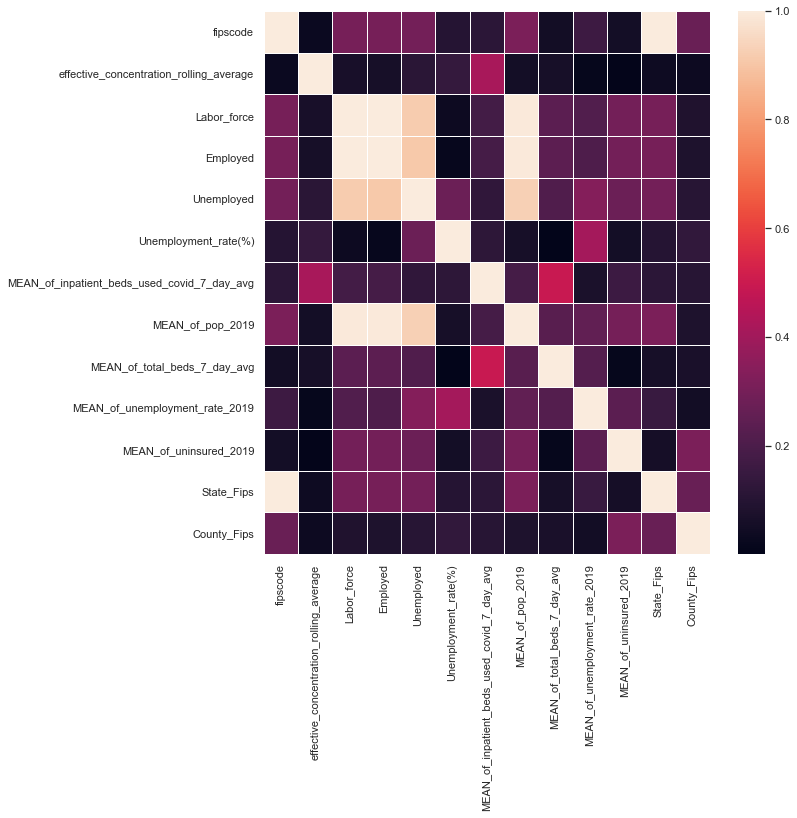

In [95]:
# Applying the .heatmap method to depict the relationships visually
sns.set(rc={'figure.figsize':(10, 10)})

sns.heatmap(df.corr().abs(), linewidths=.5)
sns.color_palette("crest")
plt.savefig('heatmap');

In [97]:
#creating list of correlation features 
ww_corr = df.corr()['effective_concentration_rolling_average'].map(abs).sort_values(ascending=False)
ww_corr

effective_concentration_rolling_average        1.000000
MEAN_of_inpatient_beds_used_covid_7_day_avg    0.417650
Unemployment_rate(%)                           0.139838
Unemployed                                     0.113040
Labor_force                                    0.064256
MEAN_of_total_beds_7_day_avg                   0.062321
Employed                                       0.060882
MEAN_of_pop_2019                               0.052066
State_Fips                                     0.038271
County_Fips                                    0.031580
fipscode                                       0.028216
MEAN_of_unemployment_rate_2019                 0.012341
MEAN_of_uninsured_2019                         0.007844
Name: effective_concentration_rolling_average, dtype: float64

In [100]:
hospitalizations_corr = df.corr()['MEAN_of_inpatient_beds_used_covid_7_day_avg'].map(abs).sort_values(ascending=False)
hospitalizations_corr

MEAN_of_inpatient_beds_used_covid_7_day_avg    1.000000
MEAN_of_total_beds_7_day_avg                   0.494471
effective_concentration_rolling_average        0.417650
MEAN_of_pop_2019                               0.183600
Employed                                       0.180357
Labor_force                                    0.178300
MEAN_of_uninsured_2019                         0.158641
Unemployed                                     0.128656
Unemployment_rate(%)                           0.119474
fipscode                                       0.117343
State_Fips                                     0.116371
County_Fips                                    0.102085
MEAN_of_unemployment_rate_2019                 0.072988
Name: MEAN_of_inpatient_beds_used_covid_7_day_avg, dtype: float64

In [134]:
df_ww_rc.corr()

,fipscode,effective_concentration_rolling_average,age_under_5_2019,age_over_18_2019,age_over_65_2019,age_over_85_2019,asian_2019,black_2019,hispanic_2019,native_2019,...,pop_2019,poverty_2019,poverty_65_and_over_2019,poverty_under_18_2019,unemployment_rate_2019,uninsured_2019,uninsured_65_and_older_2019,uninsured_under_19_2019,uninsured_under_6_2019,veterans_2019
fipscode,1.000000,0.026989,-0.007914,0.069474,-0.066224,-0.074665,-0.098371,-0.026876,-0.346324,-0.027774,...,-0.320288,0.016101,-0.176855,-0.044242,-0.155018,-0.054949,-0.110824,0.102168,0.140108,0.138465
effective_concentration_rolling_average,0.026989,1.000000,-0.035931,0.045044,0.054773,0.036024,-0.072865,0.042066,-0.067612,-0.022952,...,-0.049985,0.048926,0.032793,0.060770,0.010479,0.006171,-0.078078,0.005219,0.029261,0.037110
age_under_5_2019,-0.007914,-0.035931,1.000000,-0.880677,-0.673571,-0.639102,0.110560,0.317357,0.303367,0.249625,...,0.123820,0.004162,0.022356,0.176119,-0.008436,0.329871,0.342616,0.119964,0.043274,0.030158
age_over_18_2019,0.069474,0.045044,-0.880677,1.000000,0.532242,0.546268,-0.099996,-0.154930,-0.231999,-0.281934,...,-0.068412,0.263875,0.213706,0.073689,0.049893,-0.214520,-0.230680,-0.085863,-0.034046,-0.121684
age_over_65_2019,-0.066224,0.054773,-0.673571,0.532242,1.000000,0.857934,-0.343223,-0.263659,-0.283208,-0.140893,...,-0.127936,-0.092857,-0.086036,0.006134,0.117975,-0.172890,-0.331584,-0.054859,-0.051108,0.244229
age_over_85_2019,-0.074665,0.036024,-0.639102,0.546268,0.857934,1.000000,-0.192274,-0.177204,-0.186646,-0.326757,...,-0.006823,-0.061536,-0.024215,0.001802,0.137893,-0.250061,-0.271979,-0.175002,-0.124999,-0.039486
asian_2019,-0.098371,-0.072865,0.110560,-0.099996,-0.343223,-0.192274,1.000000,-0.016746,0.206295,-0.130874,...,0.434485,-0.308203,-0.061533,-0.337164,-0.057946,-0.223425,0.286264,-0.254324,-0.258186,-0.309460
black_2019,-0.026876,0.042066,0.317357,-0.154930,-0.263659,-0.177204,-0.016746,1.000000,0.038948,-0.203834,...,0.167127,0.410587,0.365711,0.577534,0.538583,0.319595,0.174701,-0.011909,-0.086792,-0.040303
hispanic_2019,-0.346324,-0.067612,0.303367,-0.231999,-0.283208,-0.186646,0.206295,0.038948,1.000000,0.168256,...,0.625222,0.154683,0.507902,0.196983,0.220744,0.525930,0.685153,0.192699,0.021472,-0.338532
native_2019,-0.027774,-0.022952,0.249625,-0.281934,-0.140893,-0.326757,-0.130874,-0.203834,0.168256,1.000000,...,-0.104679,0.036274,0.017042,0.061098,-0.004103,0.210105,0.184181,0.323644,0.312849,0.195181


In [62]:
corr= df_ww_rc_19.corr()

In [90]:
correlation = corr.iloc[::-1,::]
correlation

,fipscode,effective_concentration_rolling_average,MEAN_of_inpatient_beds_used_covid_7_day_avg,MEAN_of_total_beds_7_day_avg,Perc_used_covid_over_pop,MEAN_of_pop_2019,age_under_5_2019,age_over_18_2019,age_over_65_2019,age_over_85_2019,...,pop_2019,poverty_2019,poverty_65_and_over_2019,poverty_under_18_2019,unemployment_rate_2019,uninsured_2019,uninsured_65_and_older_2019,uninsured_under_19_2019,uninsured_under_6_2019,veterans_2019
veterans_2019,0.127884,0.037665,0.005037,-0.082087,0.074457,-0.338313,0.036186,-0.127652,0.240313,-0.034883,...,-0.338313,-0.118373,-0.333785,-0.004680,-0.030314,0.045533,-0.276048,0.118219,0.059450,1.000000
uninsured_under_6_2019,0.151418,0.030104,0.008932,-0.192929,0.334416,-0.123210,0.035634,-0.025777,-0.040399,-0.127789,...,-0.123210,0.268579,0.038151,0.127416,0.086530,0.454734,0.180399,0.909610,1.000000,0.059450
uninsured_under_19_2019,0.107541,0.006931,0.060224,-0.176019,0.241877,0.038130,0.118079,-0.083195,-0.051825,-0.176666,...,0.038130,0.280701,0.144697,0.184635,0.100567,0.717210,0.392476,1.000000,0.909610,0.118219
uninsured_65_and_older_2019,-0.106185,-0.077447,0.094939,0.046361,-0.189052,0.538844,0.343110,-0.229762,-0.333761,-0.275011,...,0.538844,-0.018392,0.391330,0.072382,0.133426,0.599772,1.000000,0.392476,0.180399,-0.276048
uninsured_2019,-0.052253,0.008685,0.160196,-0.011780,0.093965,0.295187,0.330269,-0.213951,-0.174512,-0.251666,...,0.295187,0.434171,0.436516,0.412629,0.240344,1.000000,0.599772,0.717210,0.454734,0.045533
unemployment_rate_2019,-0.161397,0.011287,0.075134,0.219204,-0.048347,0.255824,-0.004935,0.046014,0.113805,0.140438,...,0.255824,0.556681,0.435166,0.683619,1.000000,0.240344,0.133426,0.100567,0.086530,-0.030314
poverty_under_18_2019,-0.042984,0.061572,0.143893,0.232167,0.100445,0.079403,0.175002,0.074018,0.006927,0.002908,...,0.079403,0.852638,0.629042,1.000000,0.683619,0.412629,0.072382,0.184635,0.127416,-0.004680
poverty_65_and_over_2019,-0.174893,0.033815,0.119084,0.165684,-0.017212,0.423187,0.021212,0.214067,-0.084701,-0.022935,...,0.423187,0.591734,1.000000,0.629042,0.435166,0.436516,0.391330,0.144697,0.038151,-0.333785
poverty_2019,0.018156,0.050033,0.120749,0.130812,0.334075,0.007145,0.002309,0.265161,-0.092807,-0.060690,...,0.007145,1.000000,0.591734,0.852638,0.556681,0.434171,-0.018392,0.280701,0.268579,-0.118373
pop_2019,-0.313770,-0.050377,0.183186,0.224420,-0.329291,1.000000,0.118118,-0.062076,-0.118535,-0.012289,...,1.000000,0.007145,0.423187,0.079403,0.255824,0.295187,0.538844,0.038130,-0.123210,-0.338313


In [69]:
#Examining correlation between covid rates and poverty
df_ww_rc_19.corr()['Perc_used_covid_over_pop']['poverty_2019']

0.3340745788444416

In [133]:
#Finding the thresholds 
df_ww_rc_19.poverty_2019.describe()

count    2795.000000
mean       12.213095
std         4.360195
min         3.400000
25%         9.200000
50%        12.000000
75%        14.900000
max        28.300000
Name: poverty_2019, dtype: float64

In [143]:
qt_1, mid, qt_3= df_ww_rc_19.poverty_2019.quantile([0.10,0.5,0.90]).values.tolist()
qt_3

17.1

In [148]:
df_ww_rc_19[df_ww_rc_19.poverty_2019<=qt_1].fipscode.value_counts()

18057    50
42091    43
51179    36
36059    32
27037    21
51107    20
42029    19
33013    19
20091    18
49011    18
51013    17
Name: fipscode, dtype: int64

In [149]:
high_pov_fips=df_ww_rc_19[df_ww_rc_19.poverty_2019>=qt_3].fipscode.value_counts().index.tolist()

In [151]:
low_pov_fips= df_ww_rc_19[df_ww_rc_19.poverty_2019<=qt_1].fipscode.value_counts().index.tolist()

In [152]:
df_high_pov= df_ww_rc_19.loc[df_ww_rc_19['fipscode'].isin(high_pov_fips)]
df_low_pov= df_ww_rc_19.loc[df_ww_rc_19['fipscode'].isin(low_pov_fips)]

In [153]:
df_ww_rc_19[df_ww_rc_19.poverty_2019<=qt_1].county.value_counts()

Hamilton County      50
Montgomery County    43
Stafford County      36
Nassau County        32
Dakota County        21
Loudoun County       20
Chester County       19
Merrimack County     19
Johnson County       18
Davis County         18
Arlington County     17
Name: county, dtype: int64

In [154]:
df_ww_rc_19[df_ww_rc_19.poverty_2019>=qt_3].county.value_counts()

Suffolk County             66
Miami-Dade County          65
Harrisonburg city          42
Shelby County              27
Cumberland County          22
Latah County               21
Lowndes County             20
East Baton Rouge Parish    19
Hinds County               18
Tippecanoe County           9
Washington County           9
Name: county, dtype: int64

In [167]:
columns= ['date', 'fipscode', 'county', 'state','effective_concentration_rolling_average',
          'MEAN_of_inpatient_beds_used_covid_7_day_avg','MEAN_of_total_beds_7_day_avg',
          'Perc_used_covid_over_pop','MEAN_of_pop_2019', 'mean_household_income_2019', 
          'poverty_2019']


In [169]:
df_high_pov= df_high_pov[columns]
df_low_pov= df_low_pov[columns]

In [171]:
df_high_pov.to_csv('Combined_Datasets/df_high_pov.csv')
df_low_pov.to_csv('Combined_Datasets/df_low_pov.csv')

In [162]:
df_ww_rc_19

,date,fipscode,county,state,effective_concentration_rolling_average,MEAN_of_inpatient_beds_used_covid_7_day_avg,MEAN_of_total_beds_7_day_avg,Perc_used_covid_over_pop,MEAN_of_pop_2019,age_under_5_2019,...,poverty_2019,poverty_65_and_over_2019,poverty_under_18_2019,unemployment_rate_2019,uninsured_2019,uninsured_65_and_older_2019,uninsured_under_19_2019,uninsured_under_6_2019,veterans_2019,region
0,2021-01-08,25003,Berkshire County,MA,1173.348908,43.100000,221.800000,0.034091,126425.0,4.2,...,10.9,7.1,15.1,4.6,3.0,0.2,1.7,1.5,8.0,Northeast
1,2021-01-08,25019,Nantucket County,MA,1757.742131,NaN,42.000000,NaN,11168.0,6.3,...,NaN,NaN,NaN,3.1,4.4,0.0,2.8,3.5,5.6,Northeast
2,2021-01-08,25025,Suffolk County,MA,1140.160103,28.975000,398.056250,0.003637,796605.0,5.3,...,18.2,19.7,26.2,5.8,3.8,0.7,1.3,1.2,2.9,Northeast
3,2021-01-08,51179,Stafford County,VA,1353.447520,20.900000,144.000000,0.014240,146773.0,6.4,...,4.4,3.4,5.2,3.3,7.4,0.2,5.1,4.1,19.4,South
4,2021-01-08,53057,Skagit County,WA,327.676512,3.450000,89.666667,0.002747,125612.0,6.0,...,12.0,7.1,16.2,4.8,7.3,0.5,2.3,2.7,11.2,West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,2022-04-08,25017,Middlesex County,MA,490.791254,5.214286,NaN,0.000326,1600842.0,5.4,...,7.4,7.4,8.0,3.5,2.5,0.6,1.4,1.1,4.5,Northeast
2916,2022-04-08,18057,Hamilton County,IN,283.550331,NaN,101.060000,NaN,323117.0,6.7,...,4.6,4.2,5.3,2.4,4.4,0.3,3.4,3.8,6.0,Midwest
2917,2022-04-08,33013,Merrimack County,NH,256.952827,0.000000,NaN,NaN,149917.0,4.8,...,6.5,5.2,6.6,3.4,5.7,0.2,2.9,2.4,8.9,Northeast
2918,2022-04-08,12057,Hillsborough County,FL,137.530685,8.083333,353.000000,0.000568,1422278.0,6.2,...,14.6,11.1,19.8,5.1,12.6,1.4,6.3,4.2,8.4,South


In [161]:
pd.read_csv('ww_data_alerts.csv')[]

,Unnamed: 0,index,date,fipscode,County_Name_State,state,MEAN_of_pop_2019,ww,avg_alert,med_alert
0,0,0,2021-01-02,25003,"Berkshire County, MA",MA,126425.0,712.352592,0.000000,0.000000
1,1,1,2021-01-02,42129,"Westmoreland County, PA",PA,352590.0,1285.087095,0.000000,0.000000
2,2,2,2021-01-02,25019,"Nantucket County/town, MA",MA,11168.0,1287.079161,0.000000,0.000000
3,3,3,2021-01-02,25025,"Suffolk County, MA",MA,796605.0,915.696886,0.000000,0.000000
4,4,4,2021-01-02,51179,"Stafford County, VA",VA,146773.0,966.472012,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2886,2886,2886,2022-04-02,42055,NaN,PA,154147.0,101.385599,0.000000,0.000000
2887,2887,2887,2022-04-02,9001,NaN,CT,943926.0,323.706038,0.000000,0.000000
2888,2888,2888,2022-04-02,34013,NaN,NJ,795404.0,135.070361,135.070361,135.070361
2889,2889,2889,2022-04-02,32007,NaN,NV,52297.0,56.548384,0.000000,0.000000


In [86]:
##Running a linear regression model for inpatient beds of covid based on WasteWater concentration
sm.formula.ols(
    formula = 'MEAN_of_inpatient_beds_used_covid_7_day_avg ~ effective_concentration_rolling_average ',
    data = df_ww_rc_19).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     MEAN_of_inpatient_beds_used_covid_7_day_avg   R-squared:                       0.132
Model:                                                     OLS   Adj. R-squared:                  0.131
Method:                                          Least Squares   F-statistic:                     397.7
Date:                                         Thu, 21 Apr 2022   Prob (F-statistic):           1.68e-82
Time:                                                 16:59:56   Log-Likelihood:                -11881.
No. Observations:                                         2628   AIC:                         2.377e+04
Df Residuals:                                             2626   BIC:                         2.378e+04
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  16.8233      0.499     33.705      0.000      15.845      17.802
effective_concentration_rolling_average     0.0098      0.000     19.941      0.000       0.009       0.011
==============================================================================
Omnibus:                     1813.154   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38219.654
Skew:                           2.989   Prob(JB):                         0.00
Kurtosis:                      20.700   Cond. No.                     1.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
correlation.to_csv('correlation_df.csv')

In [67]:
data= df_ww_rc_19

''

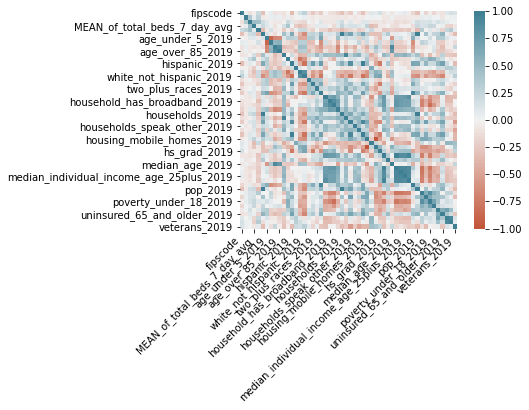

In [68]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
;

In [154]:
from pylab import rcParams
rcParams['figure.figsize'] = 7,7 
import seaborn as sns
import numpy as np
sns.set(color_codes=True, font_scale=1.2)

In [155]:
!pip install heatmapz

In [156]:
# Import the two methods from heatmap library
from heatmap import heatmap, corrplot

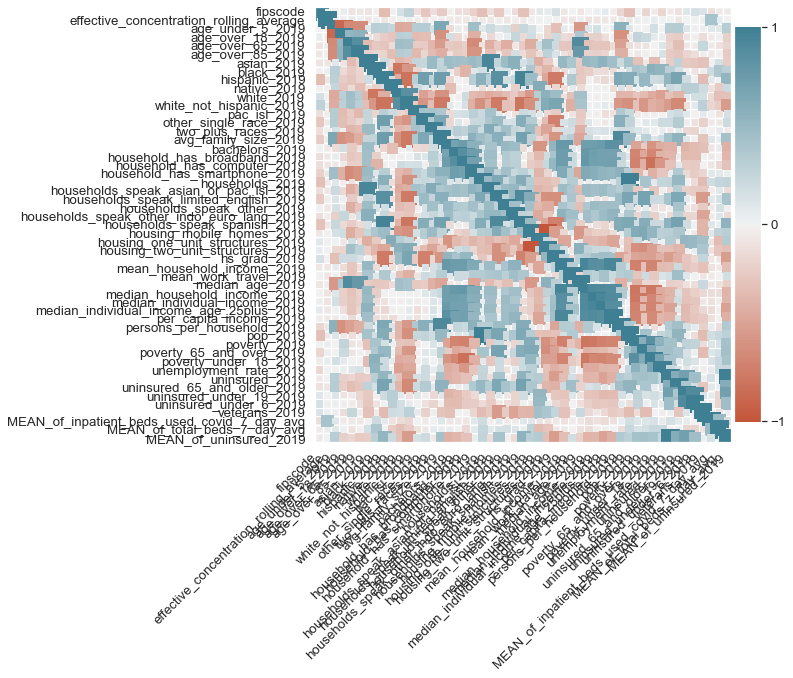

In [157]:
plt.figure(figsize=(8, 8))
corrplot(data.corr(), size_scale=300);

### Merging on the subset dataframes

In [ ]:
#creating subsets of the dataframes, runtimes shorter, see if it works first

In [572]:
df_ww.state.value_counts()
#MA 501
#PA 479
#CA 310
#FL 266
#VA 181

MA    501
PA    479
CA    310
FL    266
VA    181
IN    181
NV    164
CT    158
ME    148
KY    144
NJ    123
TN    121
IL    104
OR     95
CO     89
MN     76
MT     74
RI     60
DE     59
ID     58
SC     56
NY     54
WA     47
AR     41
KS     39
IA     38
TX     37
UT     35
AZ     34
WI     29
VT     28
NC     22
WV     21
GA     21
MO     21
LA     19
AL     19
NH     19
OH     19
MS     18
OK     15
Name: state, dtype: int64

In [473]:
df1['Stateright'] = df1['State'].str[-2:]
print(df1)

'MA'

In [659]:
#looking for states in labor force dataframe that match
df_lf_5= df_lf[df_lf['County_Name_State'].str[-2:].isin(['MA','PA', 'CA', 'FL', 'VA'])]
print(df_lf_5.shape)

df_ww_5= df_ww[df_ww['state'].isin(['MA','PA', 'CA', 'FL', 'VA'])]
print(df_ww_5.shape)

df_19_5= df_19[df_19['state'].isin
               (['Massachusetts', 'Pennsylvania', 'California','Florida','Virginia'])]
print(df_19_5.shape)

(4746, 10)
(1737, 6)
(2373, 12)


##### joining datasets using Cartesian Product

In [539]:
df_ww_5['join'] = 1
df_lf_5['join'] = 1

<ipython-input-539-ab4a76cde761>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ww_5['join'] = 1
<ipython-input-539-ab4a76cde761>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lf_5['join'] = 1


In [540]:

df_full = df_ww_5.merge(df_lf_5, on='join').drop('join', axis=1)
df_lf_5.drop('join', axis=1, inplace=True)

/Users/leratsayukova/anaconda3/envs/learn-env/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [545]:
df_lf_5.head()

,LAUS Code,State_Fips,County_Fips,County_Name_State,Period,Labor_force,Employed,Unemployed,Unemployment_rate(%),fipscode
187,CN0600100000000,06,001,"Alameda County, CA",2021-01-01,802211,744238,57973,7.2,06001
188,CN0600300000000,06,003,"Alpine County, CA",2021-01-01,626,583,43,6.9,06003
189,CN0600500000000,06,005,"Amador County, CA",2021-01-01,14326,13136,1190,8.3,06005
190,CN0600700000000,06,007,"Butte County, CA",2021-01-01,91283,83900,7383,8.1,06007
191,CN0600900000000,06,009,"Calaveras County, CA",2021-01-01,21155,19683,1472,7.0,06009


In [546]:
# #.find doesnt work on datetime types. damn
# df_full['match'] = df_full.apply(lambda x: x.sampling_week.find
#                                 (x.Period), axis=1).ge(0)

AttributeError: 'Timestamp' object has no attribute 'find'

##### joining datasets another way

In [569]:
# df_merged_5 = pd.merge(df_ww_5, df_lf_5, on=['fipscode', 'date'], how='inner')
datasets_5= [df_ww_5, df_lf_5, df_19_5]
pd.concat(datasets_5,join='outer', ignore_index=True)

,date,effective_concentration_rolling_average,region,state,name,fipscode,LAUS Code,State_Fips,County_Fips,County_Name_State,...,Unemployment_rate(%),county,county_population,health_service_area_number,health_service_area,health_service_area_population,covid_inpatient_bed_utilization,covid_hospital_admissions_per_100k,covid_cases_per_100k,covid-19_community_level
0,2020-03-04,1.740219,Northeast,MA,"Suffolk County, MA",25025,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-11,12.590344,Northeast,MA,"Suffolk County, MA",25025,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-18,58.023322,Northeast,MA,"Suffolk County, MA",25025,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-25,62.425517,South,FL,"Miami-Dade County, FL",12086,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-25,159.454813,Northeast,MA,"Suffolk County, MA",25025,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8851,2022-04-07,NaN,NaN,California,NaN,6023,NaN,NaN,NaN,NaN,...,NaN,Humboldt County,135558.0,800.0,"Humboldt, CA",135558.0,3.0,4.4,22.87,Low
8852,2022-04-07,NaN,NaN,California,NaN,6087,NaN,NaN,NaN,NaN,...,NaN,Santa Cruz County,273213.0,802.0,"Santa Cruz, CA",273213.0,2.1,1.5,77.23,Low
8853,2022-04-07,NaN,NaN,California,NaN,6029,NaN,NaN,NaN,NaN,...,NaN,Kern County,900202.0,807.0,"Kern, CA",900202.0,2.7,3.0,14.89,Low
8854,2022-04-07,NaN,NaN,California,NaN,6027,NaN,NaN,NaN,NaN,...,NaN,Inyo County,18039.0,816.0,"Inyo, CA - Mono, CA",32483.0,0.0,0.0,38.80,Low


In [660]:
df_ww_5["date"]= pd.to_datetime(df_ww_5["date"], 
                                     format='%Y-%b-%m').apply(lambda x: x.strftime('%Y-%m'))

<ipython-input-660-3d58e8a9c7df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ww_5["date"]= pd.to_datetime(df_ww_5["date"],


In [661]:
df_lf_5['date']= pd.to_datetime(df_lf_5["date"], 
                                     format='%Y-%b-%m').apply(lambda x: x.strftime('%Y-%m'))

<ipython-input-661-aeed306d838f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lf_5['date']= pd.to_datetime(df_lf_5["date"],


In [662]:
df_19_5['date']= pd.to_datetime(df_19_5["date"], 
                                     format='%Y-%b-%m').apply(lambda x: x.strftime('%Y-%m'))

<ipython-input-662-f42452f4fd3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_19_5['date']= pd.to_datetime(df_19_5["date"],


In [708]:
df_ww_5.shape

(1737, 6)

In [709]:
df_lf_5.shape

(4746, 10)

In [669]:
df_merged = pd.merge(df_ww_5, df_lf_5, on= ['date', 'fipscode'], how='inner')

In [749]:
df_merged_2= pd.merge(df_lf_5, df_ww_5, on= ['date', 'fipscode'], how='left')

In [758]:
df_merged = pd.merge(df_lf_5, df_ww_5, on=['date', 'fipscode'], how='inner')

#### California Test Case

In [802]:
df_lf_ca= df_lf[df_lf['County_Name_State'].str[-2:]=='CA']
df_lf_ca.shape
ca_fips= df_lf_ca.fipscode.values.tolist()

df_ww_ca= df_ww[df_ww['state'].str[-2:]=='CA']
df_ww_ca.shape
ca_fips2= df_ww_ca.fipscode.values.tolist()

In [803]:
ca_fips_len= len((ca_fips))
ca_fips_set= len(set(ca_fips))
ca_fips2_len= len((ca_fips2))
ca_fips2_set= len(set(ca_fips2))

In [806]:
print(f'length of Cali WW fips: {ca_fips2_len}')
print(f'length of unique Cali WW fips: {ca_fips2_set}')
print('/')
print(f'length of Cali LF fips: {ca_fips_len}')
print(f'length of unique Cali LF fips: {ca_fips_set}')


length of Cali WW fips: 310
length of unique Cali WW fips: 6
/
length of Cali LF fips: 812
length of unique Cali LF fips: 58


In [811]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

set(intersection(ca_fips, ca_fips2))

{6053, 6061, 6065, 6067, 6073, 6097}

In [809]:
len(set(intersection(ca_fips, ca_fips2)))

6

In [814]:
print(df_lf_ca.shape)
print(df_ww_ca.shape)

(812, 10)
(310, 6)


In [841]:
ca_lf_dates= df_lf_ca.date.value_counts().index.tolist()

In [839]:
ca_ww_dates= df_ww_ca.date.value_counts().index.tolist()

In [842]:
#limited by dates not fips code
intersection(ca_lf_dates, ca_ww_dates)

[Timestamp('2021-09-01 00:00:00'), Timestamp('2021-12-01 00:00:00')]

In [819]:
#inner join
df_merge_ca= pd.merge(df_lf_ca, df_ww_ca, on= ['date', 'fipscode'], how='inner')
df_merge_ca

,LAUS Code,State_Fips,County_Fips,County_Name_State,date,Labor_force,Employed,Unemployed,Unemployment_rate(%),fipscode,effective_concentration_rolling_average,region,state,name
0,CN0605300000000,06,053,"Monterey County, CA",2021-09-01,225111,212587,12524,5.6,6053,453.097739,West,CA,"Monterey County, CA"
1,CN0606100000000,06,061,"Placer County, CA",2021-09-01,186767,178835,7932,4.2,6061,1439.874052,West,CA,"Placer County, CA"
2,CN0606500000000,06,065,"Riverside County, CA",2021-09-01,1116895,1043265,73630,6.6,6065,207.912244,West,CA,"Riverside County, CA"
3,CN0605300000000,06,053,"Monterey County, CA",2021-12-01,208446,193505,14941,7.2,6053,59.582703,West,CA,"Monterey County, CA"
4,CN0606100000000,06,061,"Placer County, CA",2021-12-01,187522,181375,6147,3.3,6061,579.146377,West,CA,"Placer County, CA"


In [856]:
df_ww_ca=df_ww_ca[['date','fipscode', 'name',
                           'effective_concentration_rolling_average', 'region',
                          'state']]

,date,fipscode,effective_concentration_rolling_average,region,state,name
12,2020-04-01,6061,0.000000,West,CA,"Placer County, CA"
24,2020-04-08,6061,0.000000,West,CA,"Placer County, CA"
42,2020-04-15,6061,0.000000,West,CA,"Placer County, CA"
62,2020-04-22,6061,0.000000,West,CA,"Placer County, CA"
83,2020-04-29,6061,0.000000,West,CA,"Placer County, CA"
...,...,...,...,...,...,...
4048,2022-03-30,6097,72.583751,West,CA,"Sonoma County, CA"
4104,2022-04-06,6061,159.114029,West,CA,"Placer County, CA"
4107,2022-04-06,6065,22.627867,West,CA,"Riverside County, CA"
4108,2022-04-06,6073,142.966907,West,CA,"San Diego County, CA"


In [859]:
df_lf_ca.head(2)

,LAUS Code,State_Fips,County_Fips,County_Name_State,date,Labor_force,Employed,Unemployed,Unemployment_rate(%),fipscode
187,CN0600100000000,06,001,"Alameda County, CA",2021-01-01,802211,744238,57973,7.2,6001
188,CN0600300000000,06,003,"Alpine County, CA",2021-01-01,626,583,43,6.9,6003


In [868]:
df_lf_ca= df_lf_ca[['date', 'fipscode', 'County_Name_State','Labor_force', 'Employed', 
           'Unemployed', 'Unemployment_rate(%)']]
df_lf_ca.head()

,date,fipscode,County_Name_State,Labor_force,Employed,Unemployed,Unemployment_rate(%)
187,2021-01-01,6001,"Alameda County, CA",802211,744238,57973,7.2
188,2021-01-01,6003,"Alpine County, CA",626,583,43,6.9
189,2021-01-01,6005,"Amador County, CA",14326,13136,1190,8.3
190,2021-01-01,6007,"Butte County, CA",91283,83900,7383,8.1
191,2021-01-01,6009,"Calaveras County, CA",21155,19683,1472,7.0


In [869]:
#chopping off day
df_lf_ca['date']= pd.to_datetime(df_lf_ca['date'],
                                 format='%Y-%m-%d').apply(lambda x: x.strftime('%Y-%m'))

df_ww_ca['date']= pd.to_datetime(df_ww_ca['date'], 
                                     format='%Y-%m-%d').apply(lambda x: x.strftime('%Y-%m'))

<ipython-input-869-5b20ccf0419b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ww_ca['date']= pd.to_datetime(df_ww_ca['date'],


In [878]:
print('CA Labor number of dates: ', len((df_lf_ca.date.values.tolist())))
print('CA Labor number of unique dates: ', len(set(df_lf_ca.date.values.tolist())))
print('\n')
print('CA Wastewater number of dates: ', len((df_ww_ca.date.values.tolist())))
print('CA Wastewater number of unique dates: ', len(set(df_ww_ca.date.values.tolist())))


CA Labor number of dates:  812
CA Labor number of unique dates:  14


CA Wastewater number of dates:  310
CA Wastewater number of unique dates:  25


In [880]:
print('CA Labor number of fips: ', len((df_lf_ca.fipscode.values.tolist())))
print('CA Labor number of unique fips: ', len(set(df_lf_ca.fipscode.values.tolist())))
print('\n')
print('CA Wastewater number of fips: ', len((df_ww_ca.fipscode.values.tolist())))
print('CA Wastewater number of unique fips: ', len(set(df_ww_ca.fipscode.values.tolist())))


CA Labor number of fips:  812
CA Labor number of unique fips:  58


CA Wastewater number of fips:  310
CA Wastewater number of unique fips:  6


In [882]:
ca_lf_fips= df_lf_ca.fipscode.values.tolist()
ca_ww_fips= df_ww_ca.fipscode.values.tolist()

ca_lf_dates= df_lf_ca.date.values.tolist()
ca_ww_dates= df_ww_ca.date.values.tolist()


In [904]:
len(intersection(ca_lf_fips, ca_ww_fips))

84

In [908]:
len(set(intersection(ca_lf_dates, ca_ww_dates)))

14

##### When merging LF and WW datasets, there will be a problem:
    - multiple rolling concentrations for a county within same month

In [898]:
#merging the LF and WW datasets for Cali
##problem: multiple rolling concentrations for a county within same month
df_merge_ca= pd.merge(df_lf_ca, df_ww_ca, on=['date', 'fipscode'], how='inner')
df_merge_ca

,date,fipscode,County_Name_State,Labor_force,Employed,Unemployed,Unemployment_rate(%),effective_concentration_rolling_average,region,state,name
0,2021-01,6053,"Monterey County, CA",203073,179754,23319,11.5,157.616084,West,CA,"Monterey County, CA"
1,2021-01,6053,"Monterey County, CA",203073,179754,23319,11.5,110.229431,West,CA,"Monterey County, CA"
2,2021-01,6053,"Monterey County, CA",203073,179754,23319,11.5,98.147530,West,CA,"Monterey County, CA"
3,2021-01,6053,"Monterey County, CA",203073,179754,23319,11.5,44.648794,West,CA,"Monterey County, CA"
4,2021-01,6061,"Placer County, CA",184451,173448,11003,6.0,750.916575,West,CA,"Placer County, CA"
...,...,...,...,...,...,...,...,...,...,...,...
176,2022-02,6073,"San Diego County, CA",1586889,1522813,64076,4.0,125.025356,West,CA,"San Diego County, CA"
177,2022-02,6097,"Sonoma County, CA",248826,240223,8603,3.5,236.234522,West,CA,"Sonoma County, CA"
178,2022-02,6097,"Sonoma County, CA",248826,240223,8603,3.5,197.834419,West,CA,"Sonoma County, CA"
179,2022-02,6097,"Sonoma County, CA",248826,240223,8603,3.5,130.192174,West,CA,"Sonoma County, CA"


In [899]:
#chopping the day and doing an inner merge same effect as creating constant for LF date
df_merge_ca= pd.merge(df_ww_ca, df_lf_ca, on=['date', 'fipscode'], how='inner')
df_merge_ca

,date,effective_concentration_rolling_average,region,state,name,fipscode,County_Name_State,Labor_force,Employed,Unemployed,Unemployment_rate(%)
0,2021-01,157.616084,West,CA,"Monterey County, CA",6053,"Monterey County, CA",203073,179754,23319,11.5
1,2021-01,110.229431,West,CA,"Monterey County, CA",6053,"Monterey County, CA",203073,179754,23319,11.5
2,2021-01,98.147530,West,CA,"Monterey County, CA",6053,"Monterey County, CA",203073,179754,23319,11.5
3,2021-01,44.648794,West,CA,"Monterey County, CA",6053,"Monterey County, CA",203073,179754,23319,11.5
4,2021-01,750.916575,West,CA,"Placer County, CA",6061,"Placer County, CA",184451,173448,11003,6.0
...,...,...,...,...,...,...,...,...,...,...,...
176,2022-02,125.025356,West,CA,"San Diego County, CA",6073,"San Diego County, CA",1586889,1522813,64076,4.0
177,2022-02,236.234522,West,CA,"Sonoma County, CA",6097,"Sonoma County, CA",248826,240223,8603,3.5
178,2022-02,197.834419,West,CA,"Sonoma County, CA",6097,"Sonoma County, CA",248826,240223,8603,3.5
179,2022-02,130.192174,West,CA,"Sonoma County, CA",6097,"Sonoma County, CA",248826,240223,8603,3.5


____